In [35]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader


# Set the random seed
torch.manual_seed(0)

'''
assume that datasets are given, after preprocessing
'''
# Set the random seed
torch.manual_seed(0)

train_dataset = []
for i in range(10):
    if i <=5 :
        train_dataset += list(zip(torch.stack([torch.normal(0, 1, (22, 128, 8)) for _ in range(50)]), torch.zeros(50, dtype=torch.int)))
    else:
        train_dataset += list(zip(torch.stack([torch.normal(5, 1, (22, 128, 8)) for _ in range(50)]), torch.ones(50, dtype=torch.int)))

test_dataset = []
for i in range(10):
    if i <=5 :
        test_dataset += list(zip(torch.stack([torch.normal(0, 1, (22, 128, 8)) for _ in range(50)]), torch.zeros(50, dtype=torch.int)))
    else:
        test_dataset += list(zip(torch.stack([torch.normal(5, 1, (22, 128, 8)) for _ in range(50)]), torch.ones(50, dtype=torch.int)))

validation_dataset = []
for i in range(10):
    if i <=5 :
        validation_dataset += list(zip(torch.stack([torch.normal(0, 1, (22, 128, 8)) for _ in range(50)]), torch.zeros(50, dtype=torch.int)))
    else:
        validation_dataset += list(zip(torch.stack([torch.normal(5, 1, (22, 128, 8)) for _ in range(50)]), torch.ones(50, dtype=torch.int)))

In [36]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset

class CustomEEGDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.raw = dataset
        self.EEG = torch.stack([t[0] for t in self.raw])
        self.labels = torch.stack([t[1] for t in self.raw])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.EEG[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

generator = torch.Generator().manual_seed(42)

def split_datasets(dataset, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, generator=None):
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_dataset, validation_dataset, test_dataset = split_datasets(torch.load('/home/dhyun/project/FYP/chb01.pt'), train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, generator=generator)

In [56]:
chb21 = torch.load('/Users/daeheonkwon/Downloads/chb21.pt')
chb21 = CustomEEGDataset(chb21)
chb21

In [59]:
indices = []
for i in range(len(chb21.labels)):
    if chb21.labels[i] == 1:
        indices.append(i)

start_indices = [indices[0]]
end_indices = []
for i in range(1, len(indices)):
    if indices[i] != indices[i-1] + 1:
        end_indices.append(indices[i-1])
        start_indices.append(indices[i])
end_indices.append(indices[-1])

start_indices, end_indices



([66068, 71229, 73794, 78264], [66348, 71480, 74197, 78327])

In [51]:
train_dataset = CustomEEGDataset(train_dataset)
validation_dataset = CustomEEGDataset(validation_dataset)
test_dataset = CustomEEGDataset(test_dataset)

def get_dataloaders(dataset, batch_size=50):
    class_inds = [torch.where(dataset.labels == class_idx)[0]
                for class_idx in torch.unique(dataset.labels)]

    dataloaders = [
        DataLoader(
            dataset=Subset(dataset, inds),
            batch_size=batch_size,
            shuffle=True,
            drop_last=False)
        for inds in class_inds]
    
    return dataloaders

In [55]:
iterators = get_dataloaders(train_dataset)


4

In [38]:
''' Defining the model'''
from tqdm.notebook import tqdm
import numpy as np
import torch.nn as nn
torch.manual_seed(0)

class SciCNN(nn.Module):

    def __init__(self):
        super(SciCNN, self).__init__()        

        self.inception1 = Inception(8, 8, 16, 8, 8)
        self.maxpool1 = nn.MaxPool2d((1, 4), stride=(1, 4), ceil_mode=True)
        self.inception2 = Inception(16, 16, 8, 16, 4)
        self.maxpool2 = nn.MaxPool2d((1, 4), stride=(1, 4), ceil_mode=True)
        self.inception3 = Inception(32, 32, 4, 32, 2)
        self.maxpool3 = nn.MaxPool2d((1, 8), stride=(1, 8), ceil_mode=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(22*64, 16)
        self.npc = NPC()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.inception1(x)
        x = self.maxpool1(x)
        x = self.inception2(x)
        x = self.maxpool2(x)
        x = self.inception3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        # x = self.dropout(x)
        x = self.fc(x)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, ch1, ch1_kernel, ch2, ch2_kernel):
        super(Inception, self).__init__()
        self.branch1 = BasicConv1d(in_channels, ch1, kernel=(1, ch1_kernel), padding=(0, (ch1_kernel-1)//2))
        self.branch2 = BasicConv1d(in_channels, ch2, kernel=(1, ch2_kernel), padding=(0, (ch2_kernel-1)//2))
        self.se = SEModule()

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        concat = torch.cat([branch1, branch2], dim=1)
        return self.se(concat)
        
class SEModule(nn.Module):
    def __init__(self, channels=22, reduction=4):
        super(SEModule, self).__init__()
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        out = torch.squeeze(self.globalAvgPool(x))
        out = self.fc(out).view(x.size(0), x.size(1), 1, 1)
        out = x * out.expand_as(x)
        # return out.permute(0, 3, 1, 2)
        return x.permute(0, 3, 1, 2)
    
class BasicConv1d(nn.Module): 
    def __init__(self, in_channels, out_channels, kernel, padding):
        super(BasicConv1d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding, bias=True),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU()
                            )
    
    def forward(self, x):
        return self.conv(x)
    
class NPC(nn.Module):
    def __init__(self, num_clusters=256):
        super(NPC, self).__init__()
        # 256 predefined positions of NPC clusters
        self.position = nn.Parameter(torch.from_numpy(np.random.uniform(0, 1, (num_clusters, 16, 1))).to(torch.float32), requires_grad=True)
        self.label = nn.Parameter(torch.ones(num_clusters), requires_grad=False)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #0
loss file saved! ../loss/val_loss_log
Trainloss = 24.51 ValLoss = 27.78 TrainTime = 0.6991s ValTime = 0.1789s 
Sensitivity = 0 Specificity = 1 

Epoch #1
loss file saved! ../loss/val_loss_log
Trainloss = 8.844 ValLoss = 32.16 TrainTime = 0.2316s ValTime = 0.1343s 
Sensitivity = 1 Specificity = 0 

Epoch #2
loss file saved! ../loss/val_loss_log
Trainloss = 9.023 ValLoss = 31.27 TrainTime = 0.2403s ValTime = 0.2144s 
Sensitivity = 1 Specificity = 1 

Epoch #3
loss file saved! ../loss/val_loss_log
Trainloss = 6.71 ValLoss = 30.8 TrainTime = 0.2076s ValTime = 0.1531s 
Sensitivity = 1 Specificity = 1 

Epoch #4
loss file saved! ../loss/val_loss_log
Trainloss = 6.696 ValLoss = 31.79 TrainTime = 0.2103s ValTime = 0.1262s 
Sensitivity = 0 Specificity = 1 

Epoch #5
loss file saved! ../loss/val_loss_log
Trainloss = 6.654 ValLoss = 29.98 TrainTime = 0.2101s ValTime = 0.1437s 
Sensitivity = 0 Specificity = 0.8333 

Epoch #6
loss file saved! ../loss/val_loss_log
Trainloss = 6.426 ValLoss 

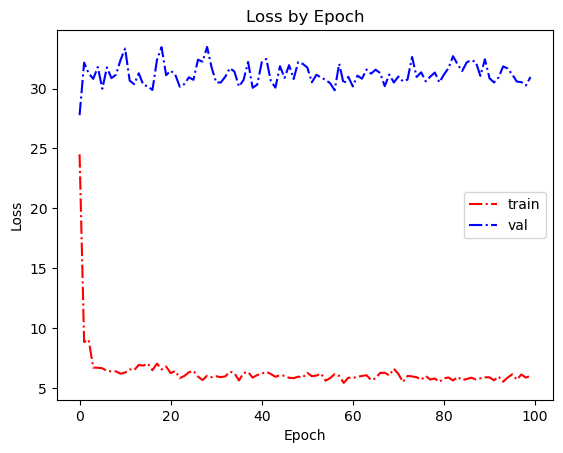

In [49]:
import numpy as np
import torch
import torch.nn as nn
import time
from matplotlib import pyplot as plt


def npc_training_loss(output, label, model):
    # output: (batch_size, 16, 1)
    mean_output = torch.mean(output, dim=0)
    distances = torch.norm(mean_output.view(1, -1, 1) - model.npc.position.data, dim=1).squeeze()
    closest_position_index = torch.argmin(distances)
    closest_position = model.npc.position[closest_position_index]
    loss = torch.norm(mean_output - closest_position)
    return loss

def npc_validation_loss(output, model):
    mean_output = torch.mean(output, dim=0)
    
    distances = torch.norm(mean_output.view(1, -1, 1) - model.npc.position.data, dim=1).squeeze()
    
    # Sort distances in descending order and get the sorted indexes
    sorted_indexes = torch.argsort(distances, descending=False)
    # Sort model.npc.position using the sorted indexes
    sorted_labels = model.npc.label[sorted_indexes]
    sorted_positions = model.npc.position[sorted_indexes]

    for i, label in enumerate(sorted_labels):
        if label != 2:
            closest_position = sorted_positions[i]
            closest_label = label
            break

    return torch.norm(mean_output - closest_position), closest_label

def train_epoch(model, dataloaders, optimizer, loss_type, device):
    model.train()
    start_epoch = time.perf_counter()
    loss = 0.
    iterators = list(map(iter, dataloaders))
    total_length = sum([len(itr) for itr in iterators])
    while iterators:
        try:
            iterator = np.random.choice(iterators)
            images, labels = next(iterator)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            train_loss = loss_type(model(images), labels, model)
            loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
        except StopIteration:
            iterators.remove(iterator)
    return loss/total_length, time.perf_counter() - start_epoch

'''Calibration: 2 minutes of seizure-free data / labeling NPC clusters'''
def calibrate(model, dataloaders, device): 
    model.eval()
    start = time.perf_counter()
    iterators = list(map(iter, dataloaders))
    iterators = iterators[0] # only use seizure-free class for calibration
    with torch.no_grad():  # using context manager
        for _ in range(128*120): # 128 samples per second, 120 seconds: 2-minute calibration
            # or keep batch size 64 and run 240 times?
            images, _ = next(iterators)
            images = images.to(device)
            output = model(images)
            mean_output = torch.mean(output, dim=0) # unnecessary, since batch size is 1. left for consistency
            distances = torch.norm(mean_output.view(1, -1, 1) - model.npc.position.data, dim=1).squeeze()
            closest_position_index = torch.argmin(distances)
            model.npc.label[closest_position_index] = 0
    return time.perf_counter() - start

def validate_sample(model, dataloaders, loss_type, device):
    model.eval()
    start = time.perf_counter()
    loss = 0.
    confusion_matrix = np.zeros((2, 2))
    iterators = list(map(iter, dataloaders))
    total_length = sum([len(itr) for itr in iterators])
    with torch.no_grad():  # using context manager
        while iterators:
            try:
                iterator = np.random.choice(iterators)
                images, labels = next(iterator)
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                val_loss = loss_type(output, model)
                loss += val_loss[0].item()
                pred = val_loss[1].item()
                labels = labels.cpu().numpy()
                confusion_matrix[0, 0] += np.sum(np.logical_and(pred == 0, labels == 0))
                confusion_matrix[0, 1] += np.sum(np.logical_and(pred == 0, labels == 1))
                confusion_matrix[1, 0] += np.sum(np.logical_and(pred == 1, labels == 0))
                confusion_matrix[1, 1] += np.sum(np.logical_and(pred == 1, labels == 1))
            except StopIteration:
                iterators.remove(iterator)
            
    return loss/total_length, confusion_matrix/total_length, time.perf_counter() - start



def save_model(exp_dir, epoch, model, optimizer, best_val_loss, is_new_best):
    torch.save(
        {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'exp_dir': exp_dir
        },
        f= exp_dir + '/model.pt'
    )

    if is_new_best[0]:
        os.system(f'cp {exp_dir}/model.pt {exp_dir}/best_loss_model.pt')
    if is_new_best[1]:
        os.system(f'cp {exp_dir}/model.pt {exp_dir}/best_sensitivity_model.pt')
    if is_new_best[2]:
        os.system(f'cp {exp_dir}/model.pt {exp_dir}/best_specificity_model.pt')

def train():
    global device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    global model
    model = SciCNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    num_epochs = 100

    train_dataloaders = get_dataloaders(train_dataset)
    val_dataloaders = get_dataloaders(validation_dataset)

    best_val_loss = 1.

    best_specificity = 0.
    best_sensitivity = 0.

    train_loss_list = []
    val_loss_list = []

    val_loss_log = np.empty((0, 2))
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch #{epoch}')

        train_loss, train_time = train_epoch(model, train_dataloaders, optimizer, npc_training_loss, device)
        val_loss, confusion_matrix, val_time = validate(model, val_dataloaders, npc_validation_loss, device)
        scheduler.step()

        val_loss_log = np.append(val_loss_log, np.array([[epoch, val_loss]]), axis=0)
        file_path = '../loss/val_loss_log'
        np.save(file_path, val_loss_log)
        print(f"loss file saved! {file_path}")

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        sensitivity = confusion_matrix[1, 1]/(confusion_matrix[1, 1] + confusion_matrix[0, 1])
        specificity = confusion_matrix[0, 0]/(confusion_matrix[0, 0] + confusion_matrix[1, 0])

        is_new_best = [
            val_loss < best_val_loss,
            sensitivity > best_sensitivity and sensitivity != 1.0,
            specificity > best_specificity and specificity != 1.0
        ]
        
        best_val_loss = min(val_loss, best_val_loss)
        best_specificity = max(specificity, best_specificity)
        best_sensitivity = max(sensitivity, best_sensitivity)

        save_model('../model', epoch, model, optimizer, best_val_loss, is_new_best)

        print(
            f'Trainloss = {train_loss:.4g} ValLoss = {val_loss:.4g} TrainTime = {train_time:.4f}s ValTime = {val_time:.4f}s \n'
            f'Sensitivity = {sensitivity:.4g} Specificity = {specificity:.4g} \n'
        )

        if is_new_best[0]:
            print(f'New best val loss: {best_val_loss:.4g}')
        if is_new_best[1]:
            print(f'New best sensitivity: {best_sensitivity:.4g}')
        if is_new_best[2]:
            print(f'New best specificity: {best_specificity:.4g}')

    y1 = np.array([])
    y2 = np.array([])
    
    for i in train_loss_list:
        y1 = np.append(y1, i)
    
    for i in val_loss_list:
        y2 = np.append(y2, i)
    
    x = np.arange(0, num_epochs)
    
    plt.plot(x, y1, 'r-.', label = 'train')
    plt.plot(x, y2, 'b-.', label = 'val')
    plt.legend()
    
    plt.title('Loss by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.savefig('../figures/loss.png', dpi=300)

train()

In [50]:
train_loss_list

[720.282615852356,
 3.2523761987686157,
 1.443078100681305,
 0.9137082010507583,
 0.9641848802566528,
 0.7769076228141785,
 0.7703074604272843,
 0.39413640797138216,
 0.4687263295054436,
 0.3645155802369118,
 0.3160578705370426,
 0.4090255595743656,
 0.3208021767437458,
 0.3052355393767357,
 0.26127208918333056,
 0.400729338824749,
 0.3717788368463516,
 0.3068317860364914,
 0.2823922708630562,
 0.27870768755674363,
 0.19129448235034943,
 0.213901524245739,
 0.1882414311170578,
 0.1756413035094738,
 0.1377466104924679,
 0.10581634938716888,
 0.10981816872954368,
 0.0863400012254715,
 0.05703640878200531,
 0.04599883444607258,
 0.027231788635253905,
 0.09835157133638858,
 0.08218232654035092,
 0.07567035853862762,
 0.07841660790145397,
 0.08190993703901768,
 0.08999497070908546,
 0.10110174492001534,
 0.18575579896569253,
 0.29149041324853897,
 0.24554776549339294,
 0.23102237582206725,
 0.2238107368350029,
 0.20085471272468566,
 0.14946980476379396,
 0.12242727875709533,
 0.072918239049

In [47]:
def npc_test_loss(output, model):
    mean_output = torch.mean(output, dim=0)
    distances = torch.norm(mean_output.view(1, -1, 1) - model.npc.position.data, dim=1).squeeze()
    closest_position_index = torch.argmin(distances)
    closest_position = model.npc.position[closest_position_index]
    closest_label = model.npc.label[closest_position_index]
    return torch.norm(mean_output - closest_position), closest_label

model.eval()
test_loss, correct, total = 0, 0, 0

loss_function = npc_test_loss
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        test_loss += loss_function(output, model)[0].item()
        pred = loss_function(output, model)[1].item()
        correct += (pred==labels).sum().item()
        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

NameError: name 'device' is not defined

In [30]:
model.npc.position[231]

tensor([[ 4.9216e-41],
        [ 4.9589e-41],
        [-4.9469e-41],
        [ 4.9542e-41],
        [-4.9155e-41],
        [-5.3176e-41],
        [-4.9478e-41],
        [-4.9069e-41],
        [-4.9579e-41],
        [ 4.9275e-41],
        [-4.9113e-41],
        [ 4.9641e-41],
        [ 5.4792e-41],
        [ 4.9050e-41],
        [ 4.9223e-41],
        [-4.9148e-41]], device='cuda:0', grad_fn=<SelectBackward0>)

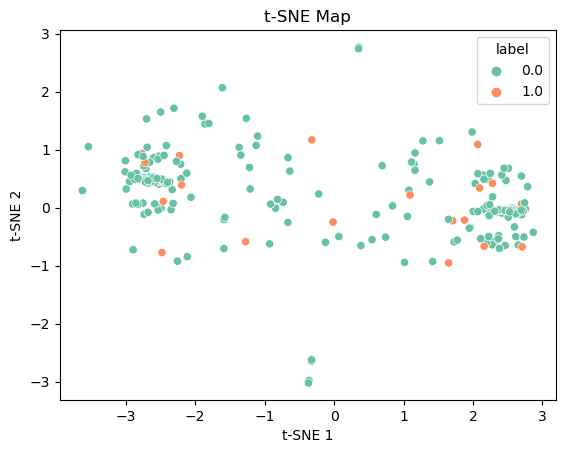

In [31]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the model.npc.position to numpy array
positions = model.npc.position.detach().cpu().numpy().squeeze()

# Convert the model.npc.label to numpy array
labels = model.npc.label.detach().cpu().numpy()

# Apply t-SNE to reduce the dimensionality
tsne = TSNE(n_components=2, random_state=0)
tsne_positions = tsne.fit_transform(positions)

# Create a DataFrame with the t-SNE positions and labels
df_tsne = pd.DataFrame({'x': tsne_positions[:, 0], 'y': tsne_positions[:, 1], 'label': labels})

# Plot the t-SNE map with hue as the label
sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette='Set2')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Map')
plt.show()

In [ ]:
model(torch.normal(0, 1, (1, 22, 128, 8)).to(device))

In [ ]:
positions.squeeze().shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
loss_plot = train_loss_list[:20]
sns.lineplot(x=range(len(loss_plot)), y=loss_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


In [ ]:
a = torch.tensor(1)
a.shape